In [1]:
import os
import sys
import warnings
import time

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
warnings.simplefilter("ignore")

from eda import show_images
from models import CustomImageDataset, compute_mean_std, get_transform, reverse_transform

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from ranger21 import Ranger21
from torch.utils.data import DataLoader
from humanize import naturaldelta

In [2]:
device = torch.device('mps') if torch.has_mps else torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


# Dataset creation

Below code calculates mean and std for images from training set, that will be used later in CustomImagedataset to normalize images

In [3]:
# dataset = CustomImageDataset(mapping="train_mapping.csv")

# batch_size = 16
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# mean, std = compute_mean_std(dataloader)
# print(f"Mean: {mean}, Std: {std}")

# Feature extractor

## EfficientNet

We'll use EfficientNet CNN part as feature extractor, thus it has been proven to be relatively fast. We choose b3 option as best balance between model response time and model complexity (measured as performance on ImageNet 21k on which it has been trained on - we choose it over ImageNet 1k believing it will learn patterns that might generalize better for our - still far away from close to ImageNet - photos)

More on EfficientNet we've choosen [here](https://huggingface.co/timm/tf_efficientnetv2_b3.in21k)

In [4]:
model = timm.create_model(
    'tf_efficientnetv2_b3.in21k',
    pretrained=True,
)
model = model.eval()

This model is quite deep, yet it is (apart from last layer) is pure CNN and we'll lock it.

In [5]:
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
   

In [6]:
timm.data.resolve_model_data_config(model)

{'input_size': (3, 240, 240),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.904,
 'crop_mode': 'center'}

In [7]:
model.default_cfg

{'url': '',
 'hf_hub_id': 'timm/tf_efficientnetv2_b3.in21k',
 'architecture': 'tf_efficientnetv2_b3',
 'tag': 'in21k',
 'custom_load': False,
 'input_size': (3, 240, 240),
 'test_input_size': (3, 300, 300),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.904,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 21843,
 'pool_size': (8, 8),
 'first_conv': 'conv_stem',
 'classifier': 'classifier'}

Even though it has been trained on 240x240 images it accepts other image sizes so we'll keep our 150x150 as input.

Limited by our PCs we choose to stick with small batch size. Many papers also suggest that smaller batch sizes tend to lower the amount of epochs neaded for model to learn the underlaying data.

In [8]:
dataset = CustomImageDataset(mapping="train_mapping.csv", transform=get_transform())

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

example_batch = next(iter(dataloader))
example_image = example_batch[0].unsqueeze(0)

In [9]:
example_batch.shape

torch.Size([16, 3, 150, 150])

EfficientNet from each image extacts tensor of 1536 * 5 * 5 features, leading to 1 - (1536 * 5 * 5) / (150 * 150 * 3) ~= 43% data compression rate on first step

In [10]:
f = model.forward_features(example_image)
f.shape

torch.Size([1, 1536, 5, 5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


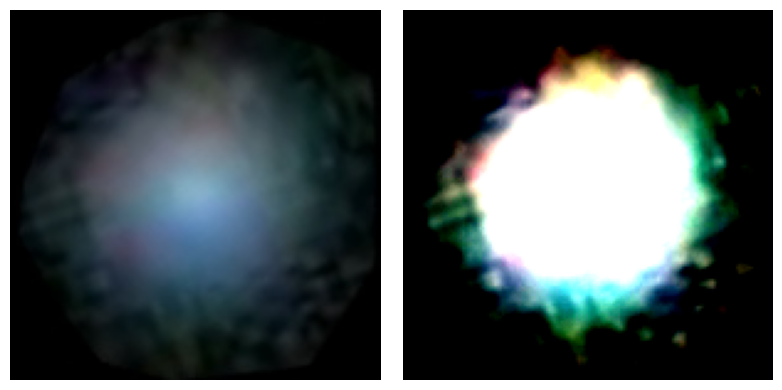

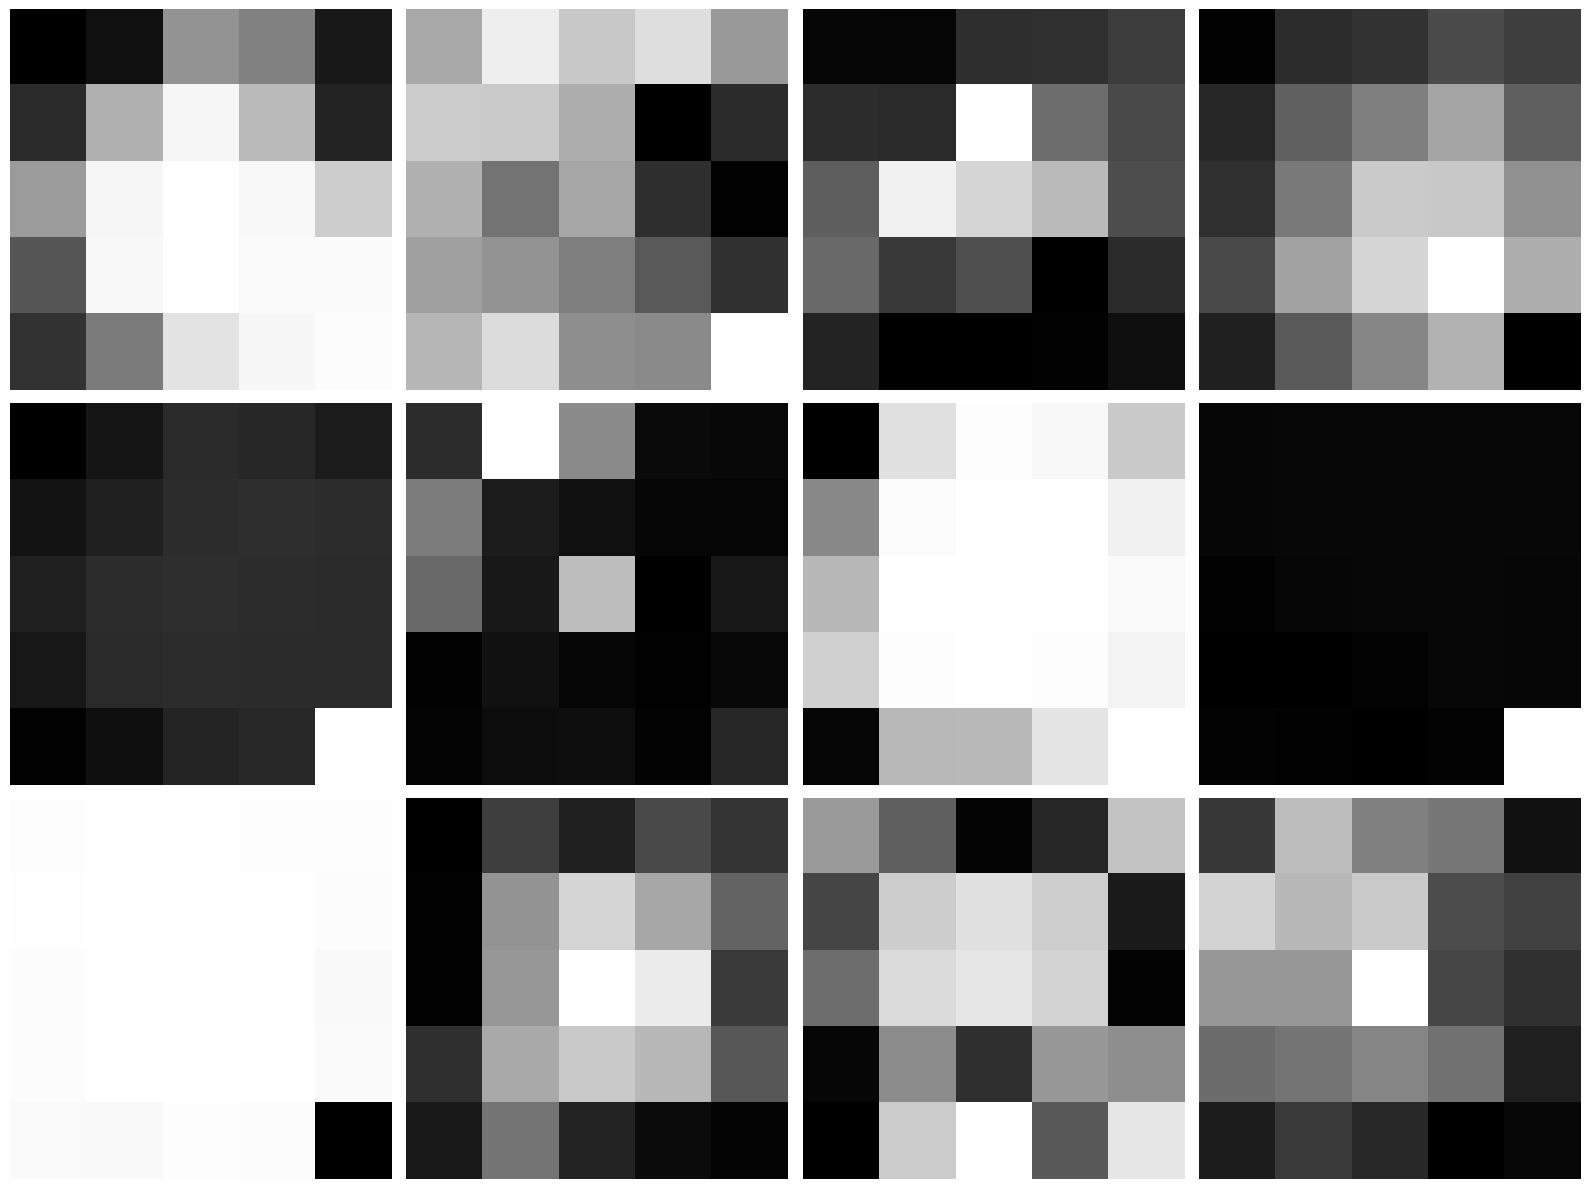

In [11]:
fix_dims = lambda img: np.transpose(img, (1, 2, 0))

images = [fix_dims(reverse_transform(example_image)), fix_dims(example_image.numpy()[0])]
sample_features_small = f[0][:12].detach().numpy()

show_images(images, ncols=2)
show_images(sample_features_small, cmap="gray")

In [12]:
del model
del dataset
del f
del example_batch
del dataloader
del images

## SimCLR

[paper](https://arxiv.org/pdf/2002.05709)

In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.efficientnet = timm.create_model('tf_efficientnetv2_b3.in21k', pretrained=True)

    def forward(self, x):
        x = self.efficientnet.forward_features(x)
        x = x.view(x.shape[0], -1)
        return x

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(ProjectionHead, self).__init__()

        hidden_dims.append(output_dim)
        last_size = input_dim
        self.hidden = nn.ModuleList()
        for hidden_size in hidden_sizes:
            self.hidden.append(
                nn.Sequential(
                    nn.Linear(last_size, hidden_size),
                    nn.GELU(),
                    nn.BatchNorm1d(hidden_size)
                )
            )
            last_size = hidden_size

    def forward(self, x):
        for hidden in self.hidden:
            x = hidden(x)
        return x

def nt_xent_loss(out_1, out_2, temperature):
    out_1 = F.normalize(out_1, dim=1)
    out_2 = F.normalize(out_2, dim=1)
    batch_size = out_1.shape[0]
    
    out = torch.cat([out_1, out_2], dim=0)
    sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
    mask = (torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=sim_matrix.device)).bool()
    sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)

    pos_sim = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos_sim = torch.cat([pos_sim, pos_sim], dim=0)

    loss = -torch.log(pos_sim / sim_matrix.sum(dim=-1)).mean()
    return loss

In [14]:
feature_in_size = 1536 * 5 * 5
hidden_sizes = [8192, 4096]
feature_out_size = 1024

encoder = Encoder().to(device)
projection_head = ProjectionHead(input_dim=feature_in_size, hidden_dims=hidden_sizes, output_dim=feature_out_size).to(device)


## Training

More on [optimizer](https://arxiv.org/pdf/2106.13731v2)

In [15]:
train_batch_size = 16
valid_batch_size = 128

train_dataset = CustomImageDataset(mapping="train_mapping.csv", transform=get_transform(train=True))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

valid_dataset = CustomImageDataset(mapping="validation_mapping.csv", transform=get_transform())
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=True)

In [16]:
num_epochs = 100
lr = 1e-3

optimizer = Ranger21(
    list(encoder.parameters()) + list(projection_head.parameters()),
    lr=lr,
    num_batches_per_epoch=len(train_dataloader),
    num_epochs=num_epochs
)

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 100 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 887328 of 1232400
warm down will decay until 3e-05 lr


In [17]:
temperature = 0.5

log_interval = 1
early_stopping_patience = 10
best_val_loss = np.inf
patience_counter = 0
best_model_state = None

In [18]:
train_losses = []
val_losses = []

master_t0 = time.time()

for epoch in range(num_epochs):
    encoder.train()
    projection_head.train()
    train_loss = 0

    train_t0 = time.time()
    for batch_idx, data in enumerate(train_dataloader):
        optimizer.zero_grad()

        data = data.to(device)
        out_1 = projection_head(encoder(data))
        out_2 = projection_head(encoder(data))

        loss = nt_xent_loss(out_1, out_2, temperature)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_dataloader)} ({100. * batch_idx / len(train_dataloader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}."
            )

        del data
        del out_1
        del out_2
        del loss

    print(f"\nTraining phase compleated, took {humanize(time.time() - train_t0)}.")

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    encoder.eval()
    projection_head.eval()
    val_loss = 0
    with torch.no_grad():

        valid_t0 = time.time()
        for data in valid_dataloader:
            data = data.to(device)
            out_1 = projection_head(encoder(data))
            out_2 = projection_head(encoder(data))
            loss = nt_xent_loss(out_1, out_2, temperature)
            val_loss += loss.item()

            del data
            del loss
            del out_1
            del out_2

    print(f"\Validation phase compleated, took {humanize(time.time() - valid_t0)}.")

    val_loss /= len(valid_dataloader)
    val_losses.append(val_loss)

    print(
        f"====> Epoch: {epoch} Average training loss: {train_loss:.4f} Validation loss: {val_loss:.4f}. Execution time {humanize(time.time() - train_t0)}.\n"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = {
            "encoder": encoder.state_dict(),
            "projection_head": projection_head.state_dict(),
            "optimizer": optimizer.state_dict(),
        }
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered. Restoring best model state.")
            encoder.load_state_dict(best_model_state["encoder"])
            projection_head.load_state_dict(best_model_state["projection_head"])
            optimizer.load_state_dict(best_model_state["optimizer"])
            break


get_path = lambda name: os.path.join("scores", name)
np.save(get_path("features_train_losses.npy"), np.array(train_losses))
np.save(get_path("features_val_losses.npy"), np.array(val_losses))
torch.save(best_model_state, get_path("features_model.pth"))

print(f"\nTraining complete. Took {humanize(time.time() - master_t0)}.")

params size saved
total param groups = 1
total params in groups = 374


KeyboardInterrupt: 